In [1]:
!pip install opendatasets --upgrade --quiet
!pip install scikit-learn --upgrade --quiet
!pip install numpy --quiet
!pip install pyarrow --quiet
!pip install plotly matplotlib seaborn --quiet

Importing the important libraries.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
# import libraries for plotting
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
import re  #for manipulating regular expressions 
import nltk  #natural language toolkit

In [5]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## **Importing Dataset**

In [6]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?select=train.csv'
od.download(dataset_url)

Skipping, found downloaded files in "./twitter-sentiment-analysis-hatred-speech" (use force=True to force download)


In [7]:
dataset_url_test = 'https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?select=test.csv'
od.download(dataset_url_test)

Skipping, found downloaded files in "./twitter-sentiment-analysis-hatred-speech" (use force=True to force download)


In [8]:
import os
data_dir = './twitter-sentiment-analysis-hatred-speech'

train_csv = data_dir + '/train.csv'
test_csv= data_dir+ '/test.csv'

os.listdir(data_dir)

['test.csv', 'train.csv']

## **Loading Datasets**

In [9]:
train_df = pd.read_csv(train_csv)
train_df 

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [10]:
test_df=pd.read_csv(test_csv)
test_df

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
...,...,...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."


In [11]:
#creating a copy of original data which will be used later for checking the result obtained.
ori_test=test_df.copy()

## **Checking for missing values in train_df**

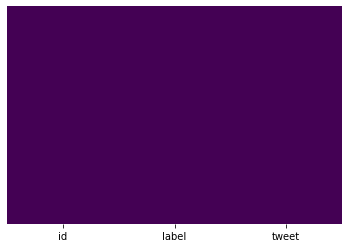

In [12]:
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap="viridis")

Therefore, it has no missing values. 

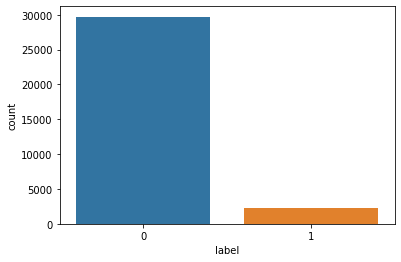

In [13]:
sns.countplot(x = train_df['label'])
plt.show()

There is a problem of data imbalancing. We need to take care of that while splitting the data into train and test.


## **Dropping useless column from test_df and train_df**

In [14]:
#id column is of no use to us so we'll drop it.
train_df.drop(["id"],axis=1,inplace=True)
train_df

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


In [15]:
test_df.drop(["id"],axis=1,inplace=True)
test_df

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."
...,...
17192,thought factory: left-right polarisation! #tru...
17193,feeling like a mermaid ð #hairflip #neverre...
17194,#hillary #campaigned today in #ohio((omg)) &am...
17195,"happy, at work conference: right mindset leads..."


From now onwards, we will be working with the train_df and create a model which will be used to predict the labels for test_df.

# **Removing the stopwords and stemming it.**

In [16]:
nltk.download("stopwords")
print(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

In [17]:
port_stem=PorterStemmer()

In [18]:
def stemming(content):
    stemmed_content=re.sub("[^a-zA-Z]"," ",content)
    stemmed_content=stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content=[port_stem.stem(word) for word in stemmed_content if not word in stopwords.words("english")]
    stemmed_content=" ".join(stemmed_content)
    return stemmed_content

In [19]:
train_df["tweet"]=train_df["tweet"].apply(stemming)

In [20]:
train_df

,label,tweet
0,0,user father dysfunct selfish drag kid dysfunct...
1,0,user user thank lyft credit use caus offer whe...
2,0,bihday majesti
3,0,model love u take u time ur
4,0,factsguid societi motiv
...,...,...
31957,0,ate user isz youuu
31958,0,see nina turner airwav tri wrap mantl genuin h...
31959,0,listen sad song monday morn otw work sad
31960,1,user sikh templ vandalis calgari wso condemn act


In [21]:
X=train_df["tweet"]
Y=train_df["label"]

In [22]:
vectorizer=TfidfVectorizer()

In [23]:
vectorizer.fit(X)
X = vectorizer.transform(X)

In [24]:
X.shape

(31962, 31307)

In [25]:
#splitting the dataset to training and testing data
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=4)

In [26]:
model=LogisticRegression()

In [27]:
model.fit(X_train,Y_train)

LogisticRegression()

In [28]:
#accuracy of the training data
X_train_prediction=model.predict(X_train)
training_data_accuracy=accuracy_score(X_train_prediction,Y_train)
print(f"Accuracy score of the training data: {training_data_accuracy}")

Accuracy score of the training data: 0.9534201572216355


In [29]:
#accuracy of the testing data
X_test_prediction=model.predict(X_test)
testing_data_accuracy=accuracy_score(X_test_prediction,Y_test)
print(f"Accuracy score of the training data: {testing_data_accuracy}")

Accuracy score of the training data: 0.9502580947911778


## **For Testing Dataset**

In [30]:
test_df["tweet"]=test_df["tweet"].apply(stemming)

In [31]:
XT=test_df["tweet"]

In [32]:
XT = vectorizer.transform(XT)
XT.shape

(17197, 31307)

In [33]:
Test_predict=model.predict(XT)
Test_predict


array([0, 0, 0, ..., 0, 0, 0])

In [34]:
count=np.unique(Test_predict,return_counts=True)
count

(array([0, 1]), array([16740,   457]))

In [35]:
ori_test[Test_predict==1]

,id,tweet
19,31982,thought factory: bbc neutrality on right wing ...
33,31996,suppo the #taiji fisherman! no bullying! no ra...
110,32073,hey @user - a $14000 ivanka bracelet? do you f...
141,32104,you might be a libtard if... #libtard #sjw #l...
159,32122,#people aren't protesting #trump because a #re...
...,...,...
17125,49088,be careful in criticizing #obama for his decis...
17128,49091,@user the uk governmentâs new #anti-semitism...
17176,49139,@user @user are the most racist pay ever!!!!!
17188,49151,"black professor demonizes, proposes nazi style..."


In [36]:
#we can add the label column in copy of test_df.
ori_test["label"]=Test_predict
ori_test

,id,tweet,label
0,31963,#studiolife #aislife #requires #passion #dedic...,0
1,31964,@user #white #supremacists want everyone to s...,0
2,31965,safe ways to heal your #acne!! #altwaystohe...,0
3,31966,is the hp and the cursed child book up for res...,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",0
...,...,...,...
17192,49155,thought factory: left-right polarisation! #tru...,1
17193,49156,feeling like a mermaid ð #hairflip #neverre...,0
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...,0
17195,49158,"happy, at work conference: right mindset leads...",0
